# Pet (Cats Vs Dogs) Classification Using Convolutional Neural Networks

This is a simple convolutional neural network project which is basically, image classification.

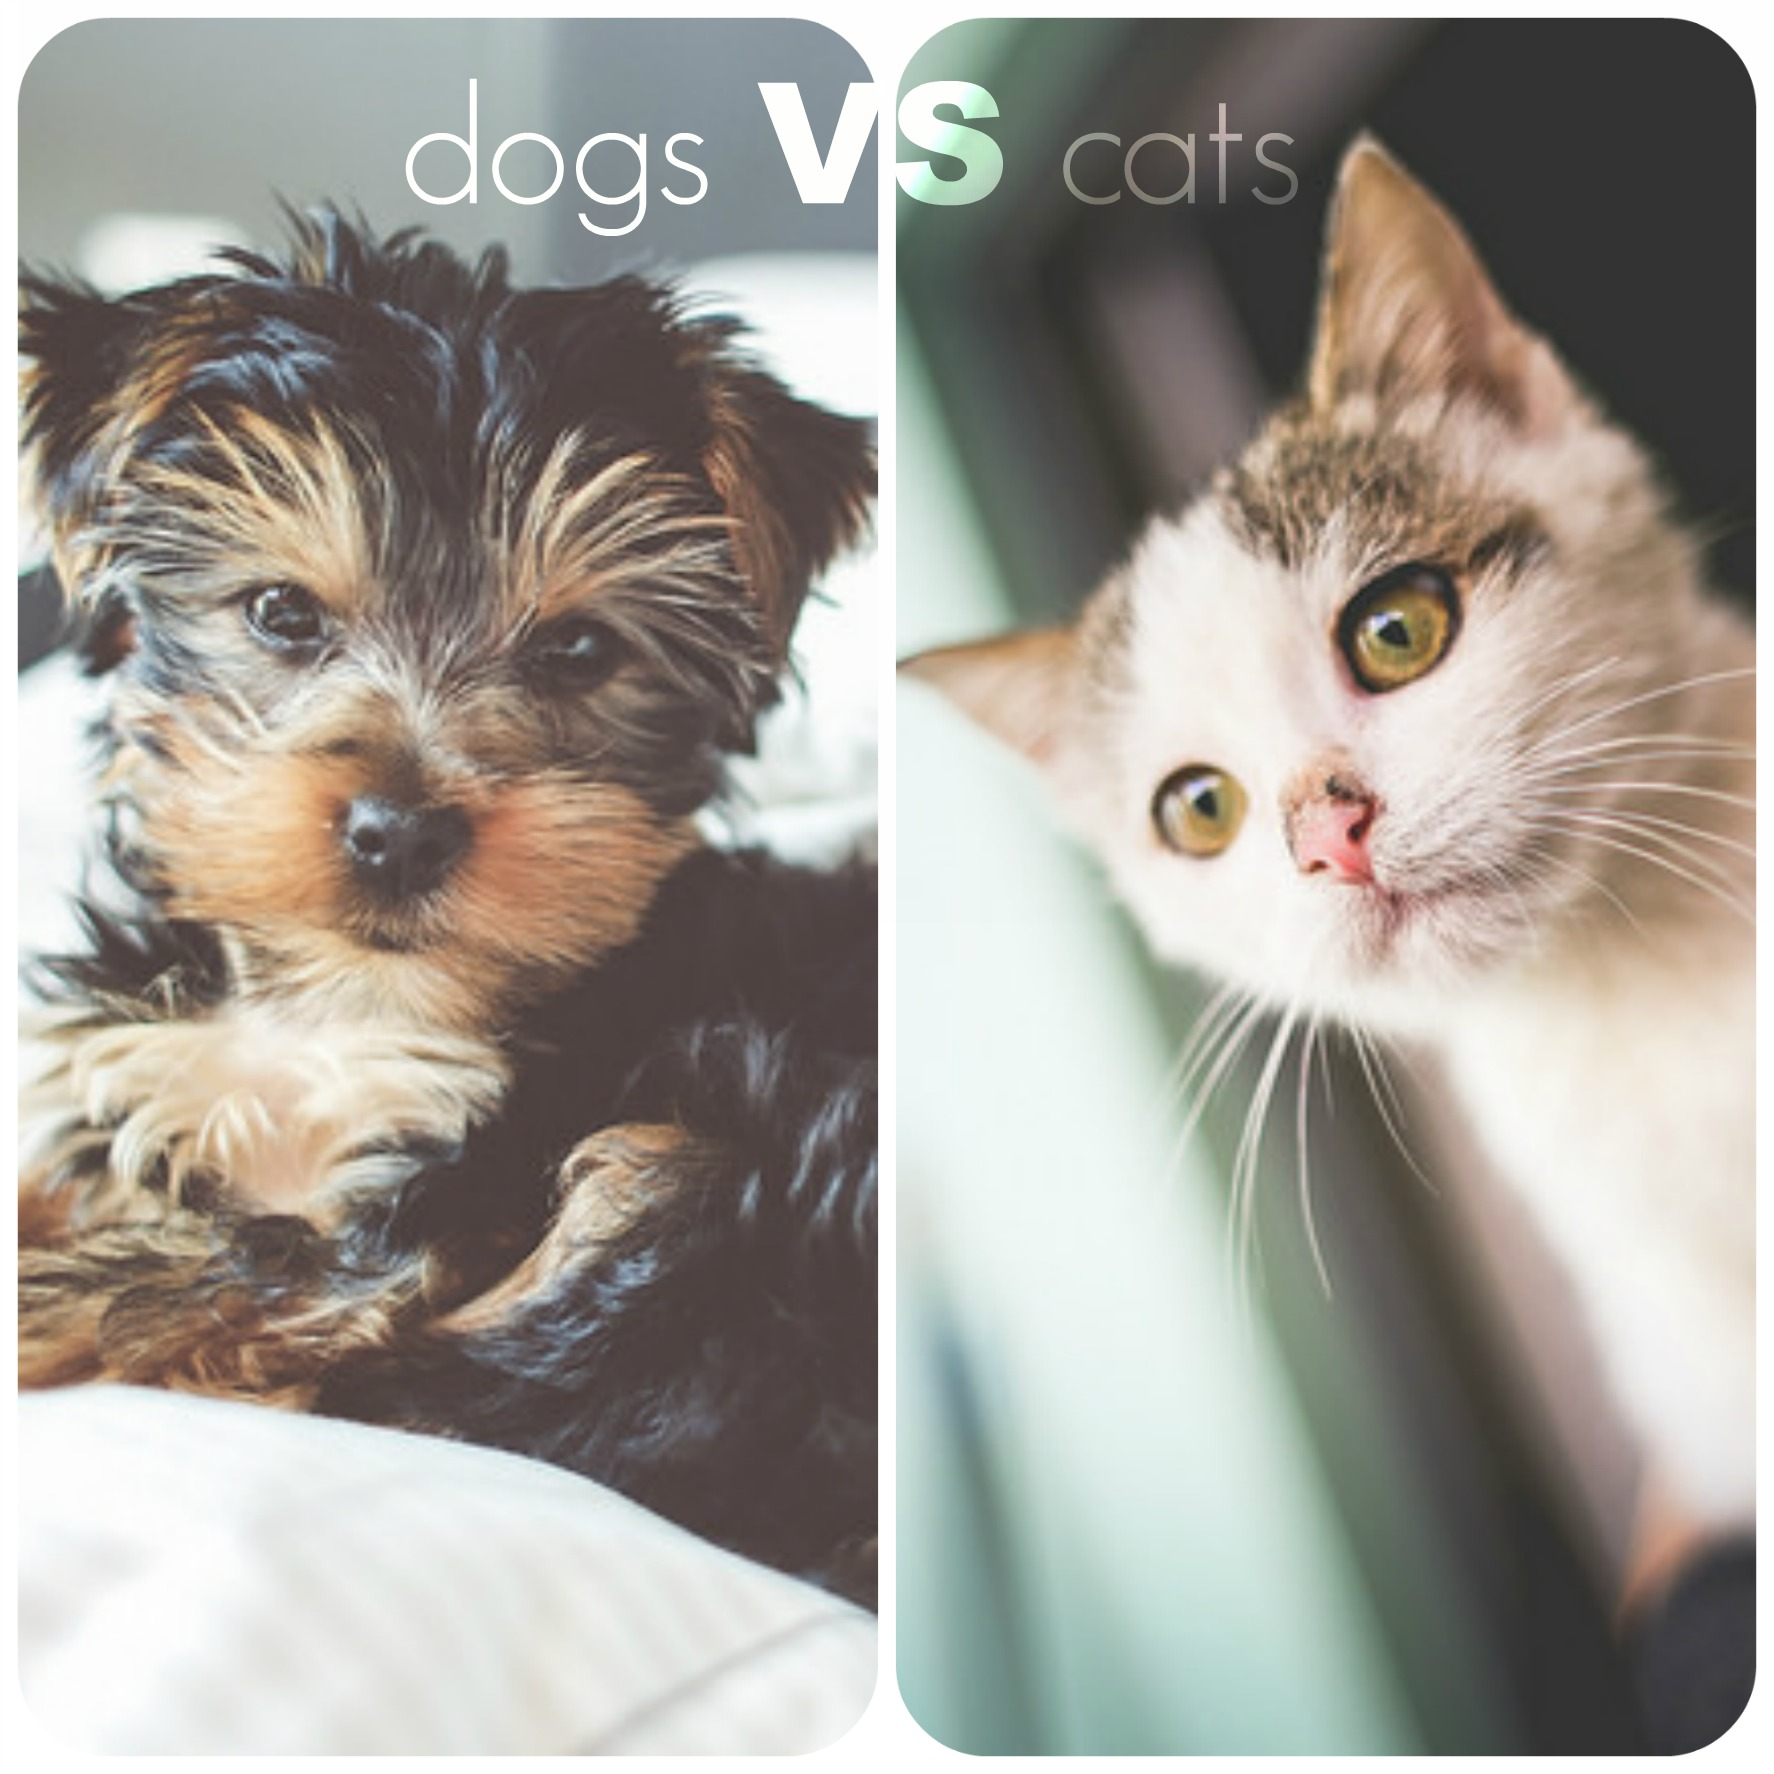

The libraries used in here include:

1.   torch (pytorch)
2.   numpy
3.   PIL
4.   matplotlib
5.   glob
6.   torchvision
7.   pandas
8.   os
9.   shutil

The model will be trained on the cat_dog dataset and will output three classes, one for cat, another for dog, and the last for neither.

Two approaches will be taken to create the model, the first being building the model from scratch, while the second will employ transfer learning, then both will be compared.



In [ ]:
# I am using google colab. To access my files, I have to mount my drive first
from google.colab import drive
drive.mount( '/content/drive' )

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Exploration

First things first, let's take a peek into what our dataset holds and explore.

In [ ]:
# Importing the necessary libraries
import numpy as np
from glob import glob

# Reading in the images
train_path = '/content/drive/MyDrive/Udacity-Intro to Pytorch/Cat_Dog_Classifier/\
kaggle_cat_dog_data/train'
test_path = '/content/drive/MyDrive/Udacity-Intro to Pytorch/Cat_Dog_Classifier/\
kaggle_cat_dog_data/test1'

tn_data = np.array( glob (train_path+'/*') )
tt_data = np.array( glob (test_path+'/*') ) 


# Print image statistics
print( 'Data Statistics.....' )
print( 'Class', '\t','train', '\t','test' )
print( 'Mixed', '\t',len(tn_data), '\t',len(tt_data) )

Data Statistics.....
Class 	 train 	 test
Mixed 	 25119 	 12573


Comparing the data statistics above with with the [origin](https://www.kaggle.com/c/dogs-vs-cats/data) of the dataset, there are clearly more images in the data loaded here than contained in the original dataset. These extras are duplicates which occurred while uploading the data to google drive. So let's factor and clean out these duplicates.

In [ ]:
# # To find how the duplicates are stored
# import re

# # reading in only the sortable parts of the filenames
# files = glob.glob1( test_path,'*'+'jpg' )

# # sorting according to the digits included in the filename:
# files = sorted( files, key=lambda x:float(re.findall("(\d+)",x)[0]) )
# files [ 450 : 460 ]

In [ ]:
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

train_data = []
print( 'Cleaning out duplicates in train data....' )
for i in tqdm_notebook( tn_data ):
  if '(' not in i:
    train_data.append( i )
print( 'Done!' )
print( 'Found {} duplicated images in train data '.format(len(tn_data) \
                                                          - len(train_data)) )

Cleaning out duplicates in train data....



Done!
Found 119 duplicated images in train data 


In [ ]:
#for the test data
test_data = []

print( 'Cleaning out duplicates in test data....' )
for i in tqdm_notebook( tt_data ):
  if '(' not in i:
    test_data.append( i )
print( 'Done!' )
print( 'Found {} duplicated images in test data '.format(len(tt_data) \
                                                          - len(test_data)) )

Cleaning out duplicates in test data....



Done!
Found 73 duplicated images in test data 


Now that we have cleaned out the duplicates, lets sort the images into the labeled folders. 

In [ ]:
import os
import shutil

# creating the new train directories
##### IMPORTANT #########
# For best practices,
# this cell is to be run only once else we get an error if the 
# folder(s) already exists..


## Uncomment the lines below and run for the first time
## to create directories

# os.mkdir( train_path+'/train' )
# os.mkdir( train_path+'/train/cat')
# os.mkdir( train_path+'/train/dog' )

Awesome.. We have succefully split the data. Let's go ahead to visualize some of the images present in the dataset. This also shows us that the datapoints are evenly distributed among the classes so we have a balanced dataset.

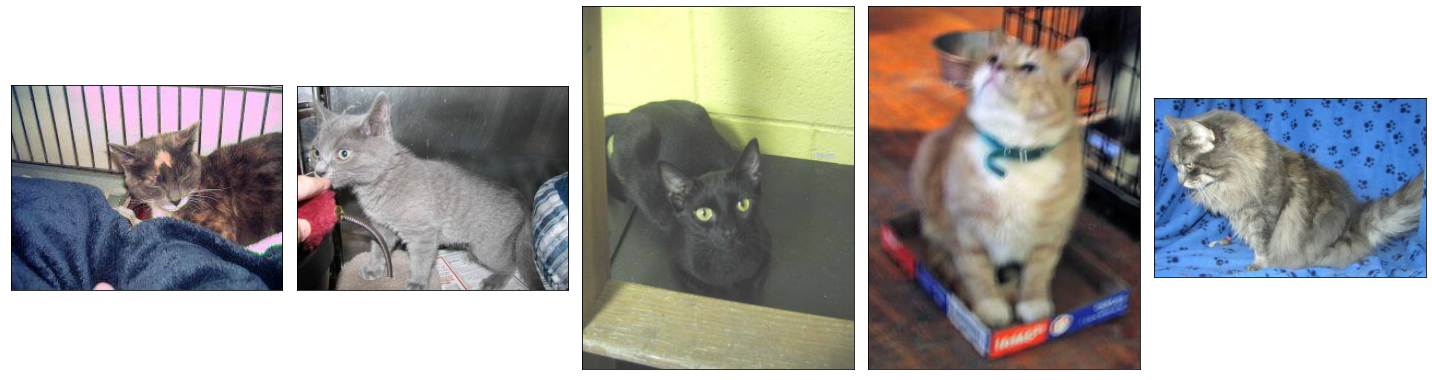

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style
from PIL import Image, ImageFile, ImageOps
ImageFile.LOAD_TRUNCATED_IMAGES = True
#style.use('ggplot')
%matplotlib inline

# setting the figure size
fig = plt.figure( figsize=(20, 8) )

# visulaizing cat images...
for i in np.arange( 5 ):
  ax = fig.add_subplot( 1, 5, i+1, xticks=[], yticks=[] )
  ax.imshow( np.squeeze( Image.open( train_data[i]) ) )
  plt.tight_layout()

Next, Let us create Dataloaders....

## Data Augmentation..

Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.

In pytorch, this can be done using the pytorch `torchvision.transforms` module. Below are some examples of the augmentation techniques I used. To learn more about `torchvison.transforms` goto: [here](https://pytorch.org/docs/stable/torchvision/transforms.html)

			 Augmenting image with ColorJitter



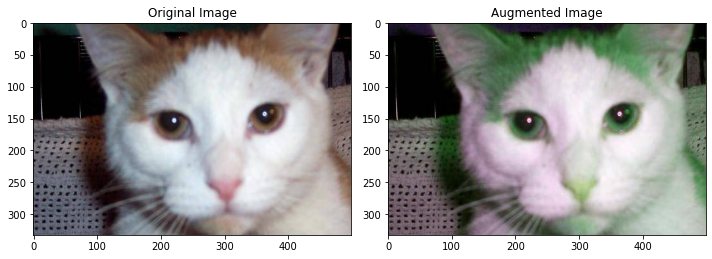

In [ ]:
import torch
import torchvision.transforms as transforms
torch.manual_seed(42)


img = Image.open( train_data[10] )
trans_img = transforms.ColorJitter( 0.0, 0.0, 0.0, 0.3 )( img )

def show_aug( img, trans_img ):
  fig, ( ax1, ax2 ) = plt.subplots( 1, 2, figsize=(10, 8) )
  ax1.imshow( img )
  ax1.title.set_text( 'Original Image' )
  ax2.imshow(trans_img)
  ax2.title.set_text( 'Augmented Image' )
  plt.tight_layout();

print( '\t\t\t Augmenting image with ColorJitter' )
print()
show_aug( img, trans_img )

			Augmenting image with RandomPerpective



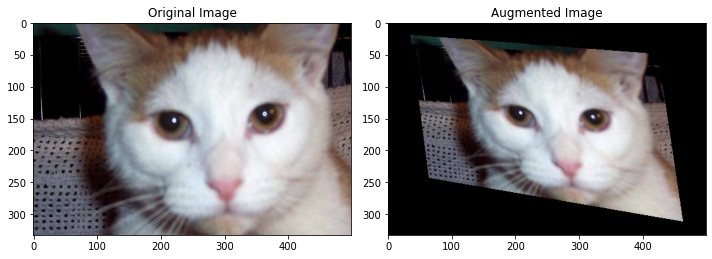

In [ ]:
trans_img = transforms.RandomPerspective( 0.6, 0.5 )( img )

print( '\t\t\tAugmenting image with RandomPerpective' )
print()
show_aug( img, trans_img )

			Augmenting image with RandomAffine



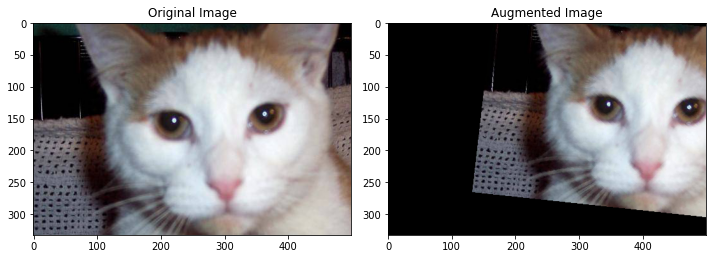

In [ ]:
trans_img = transforms.RandomAffine( 45, (0.5, 0.5), (0.8, 0.9), (0.5, 0.5) )( img )

print( '\t\t\tAugmenting image with RandomAffine' )
print()
show_aug( img, trans_img )

			Augmenting image with GaussianBlur



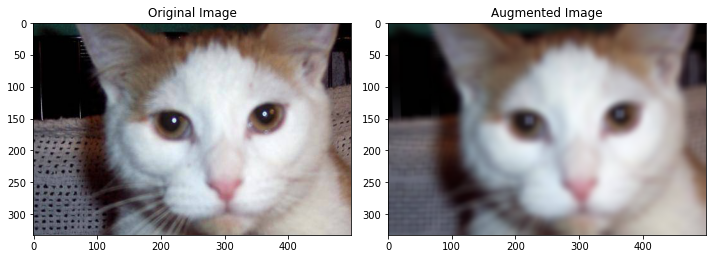

In [ ]:
trans_img = transforms.GaussianBlur( (13, 13), (33.0, 33.0) )( img )

print( '\t\t\tAugmenting image with GaussianBlur' )
print()
show_aug( img, trans_img )

With these examples, we at least have an idea of how image augmentation works and what it is all about... Let us now go ahead and define our dataloaders

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision import transforms, datasets

# Defining the transform job (augmentation included)
transform = { 'train': transforms.Compose([ transforms.RandomHorizontalFlip(),
                                            transforms.RandomRotation( 30 ),
                                            #transforms.GaussianBlur( (11, 11), (33.0, 33.0) ),
                                            transforms.ToTensor(),
                                            transforms.Normalize( (0, 0, 0), (1, 1, 1) ) 
                                            ]),
             
             'test': transforms.Compose([ transforms.ToTensor(),
                                          transforms.Normalize( (0, 0, 0), (1, 1, 1) ) ])
             }


In [ ]:
# defining num of subprocesses to use for data loading
num_workers = 0
# num of samples per batch
batch_size = 16
# fraction of data to use from the train data as validation
valid_size = 0.25

In [ ]:
# Let's create a class to help us get our own dataset
class CatDogData( Dataset ):

  def __init__( self, img_data, classes, set_type="", transforms=None ):
    super().__init__()
    self.img_data = img_data
    self.set_type = set_type
    self.classes = classes
    self.transforms = transforms


  def __getitem__( self, idx ):
    img = self.img_data[ idx ]

    ## get label
    if self.set_type=="train" or self.set_type=="valid":
      label = self.classes[ img.split('/train/')[1][:3] ]
      label = torch.tensor( label, dtype=torch.float32 )

      ## apply transforms to image
      img = Image.open( img )
      img = img.resize( (224, 224) )
      img = self.transforms( img )
      return img, label

    elif self.set_type=='test':
      img = self.transforms( img )
      return img


  def __len__( self ):
    size = len( self.img_data )
    return size

### Split dataset into train and validation sets
X_train, X_valid = train_test_split( train_data, test_size=valid_size)

In [ ]:
### Get datasets
classes = { 'dog':0, 'cat':1 }
f_train = CatDogData( X_train, classes, 'train', transform['train'] )
f_valid = CatDogData( X_valid, classes, 'valid', transform['test'] )
f_test = CatDogData( test_data, classes, 'test', transform['test'] )

### Prepare dataloaders
data_loaders = { 'train': DataLoader( f_train, batch_size=batch_size, shuffle=True,
                                     num_workers=num_workers ),
                 'valid': DataLoader( f_valid, batch_size=batch_size ),
                 'test': DataLoader( f_test, batch_size=batch_size ) 
                 }

print( 'Dataloaders preparation complete!')

Dataloaders preparation complete!


In [ ]:
images, labels = next( iter(data_loaders['train']) )
images.size(), labels.size()

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

Our dataloaders are ready... The next process is to build our network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from IPython.display import display


# Desing the model architecture
class C_net( nn.Module ):
  def __init__( self ):
    super( C_net, self ).__init__()

    ## Define the convolutional layers
    # input --> 224x224x3 image tensor
    self.conv1 = nn.Conv2d( 3, 3, 3, padding=1 )
    # input --> 224x224x3 image tensor
    self.conv11 = nn.Conv2d( 3, 16, 3, padding=1 )
    # input --> 112x112x16 image tensor
    self.conv2 = nn.Conv2d( 16, 16, 3, padding=1 )
    # input --> 112x112x16 image tensor
    self.conv21 = nn.Conv2d( 16, 32, 3, padding=1 )
    # input --> 56x56x32 image tensor
    self.conv3 = nn.Conv2d( 32, 64, 3, padding=1 )
    # input --> 28x28x64 image tensor
    self.conv4 = nn.Conv2d( 64, 64, 3, padding=1 )
    # input --> 28x28x64 image tensor
    self.conv41 = nn.Conv2d( 64, 128, 3, padding=1 )
    # input --> 14x14x128 image tensor
    self.conv5 = nn.Conv2d( 128, 256, 3, padding=1 )
    # input --> 14x14x128 image tensor
    self.conv51 = nn.Conv2d( 256, 256, 3, padding=1 )


    # pooling layers
    self.pool = nn.MaxPool2d( 2, 2 )
    # dropout
    self.dropout = nn.Dropout( 0.5 )


    # fully connected layers
    self.fc1 = nn.Linear( 256 * 7 * 7, 4096 )
    self.out = nn.Linear( 4096, 1 )
    self.sig = nn.Sigmoid()

    # define batch normalization
    self.cbnorm1 = nn.BatchNorm2d( 3 )
    self.cbnorm11 = nn.BatchNorm2d( 16 )
    self.cbnorm2 = nn.BatchNorm2d( 16 )
    self.cbnorm21 = nn.BatchNorm2d( 32 )
    self.cbnorm3 = nn.BatchNorm2d( 64 )
    self.cbnorm4 = nn.BatchNorm2d( 64 )
    self.cbnorm41 = nn.BatchNorm2d( 128 )
    self.cbnorm5 = nn.BatchNorm2d( 256 )
    self.cbnorm51 = nn.BatchNorm2d( 256 )

    self.fbnorm1 = nn.BatchNorm1d( 4096 )



  # Define forward behaviour
  def forward( self, x ):
    x = F.leaky_relu( self.cbnorm1(self.conv1(x)) )
    x = self.pool( F.leaky_relu(self.cbnorm11(self.conv11(x))) )
    x = F.leaky_relu( self.cbnorm2(self.conv2(x)) )
    x = self.pool( F.leaky_relu(self.cbnorm21(self.conv21(x))) )
    x = self.pool( F.leaky_relu(self.cbnorm3(self.conv3(x))) )
    x = F.leaky_relu( self.cbnorm4(self.conv4(x)) )
    x = self.pool( F.leaky_relu(self.cbnorm41(self.conv41(x))) )
    x = F.leaky_relu( self.cbnorm5(self.conv5(x)) )
    x = self.pool( F.leaky_relu(self.cbnorm51(self.conv51(x))) )

    # flatten input image
    x = x.view( -1, 256 * 7 * 7 )

    # Fully connected layers
    x = F.leaky_relu( self.fbnorm1(self.fc1(x)) )
    x = self.out( x )
    x = self.sig( x )
    return x


m_net = C_net()
use_cuda = torch.cuda.is_available()

if use_cuda:
  m_net.cuda()

display( summary(m_net, ( 3, 224, 224 )) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 224, 224]              84
       BatchNorm2d-2          [-1, 3, 224, 224]               6
            Conv2d-3         [-1, 16, 224, 224]             448
       BatchNorm2d-4         [-1, 16, 224, 224]              32
         MaxPool2d-5         [-1, 16, 112, 112]               0
            Conv2d-6         [-1, 16, 112, 112]           2,320
       BatchNorm2d-7         [-1, 16, 112, 112]              32
            Conv2d-8         [-1, 32, 112, 112]           4,640
       BatchNorm2d-9         [-1, 32, 112, 112]              64
        MaxPool2d-10           [-1, 32, 56, 56]               0
           Conv2d-11           [-1, 64, 56, 56]          18,496
      BatchNorm2d-12           [-1, 64, 56, 56]             128
        MaxPool2d-13           [-1, 64, 28, 28]               0
           Conv2d-14           [-1, 64,

None

 We have succefully designed our network architecture... The step is to define our train function and specify hyperparameters.

In [ ]:
# define train function
import time

def train( epochs, model, loaders_list, optimiser, loss_fn, use_cuda, save_path, verbose=True ):
  # initialize trackers
  valid_loss_min = np.Inf
  train_losses = { 'total':[], 'batch':[] }
  valid_losses = { 'total':[], 'batch':[] }
  accuracy = { 'train':[], 'valid':[] }


  print( 'Training Started......' )
  print()
  print()
  for epoch in range( 1, epochs+1 ):
    # intiating time trackers
    start_time = time.time()

    # initialize variables to monitor training and validation losses
    train_loss = []
    valid_loss = []
    train_acc = []
    valid_acc = []
    running_loss = running_loss_valid = 0.0

    ####################################################
    ################# Training Model ###################
    ####################################################

    model.train()
    for batch_idx, ( data, label ) in enumerate( data_loaders['train'] ):

      # move to GPU if available
      if use_cuda:
        data, label = data.cuda(), label.cuda()

      # reshaping labels to match the shape of the model's output, 
      # and converting to Float
      label = label.reshape( (label.shape[0], 1) )

      # clear accumulated gradients
      optimiser.zero_grad()
      # forward pass
      output = model( data )
      # calculate batch loss
      loss = loss_fn( output, label )

      ## track losses and accuracy
      # compute train loss
      train_loss.append( loss.item() )
      # compute accuracy
      train_acc.append( get_accuracy( output, label ) )

      # backward pass
      loss.backward()
      # parameter update
      optimiser.step()

      #record batch losses
      running_loss += loss.item()
      if batch_idx % 10 == 0:
        avg_loss = running_loss/10
        train_losses['batch'].append( avg_loss )
        running_loss = 0.0

    ####################################################
    ################ Validating Model ##################
    ####################################################
    model.eval()
    for batch_idx, ( data, label ) in enumerate( data_loaders['valid'] ):

      # move data to cuda if available
      if use_cuda:
        data, label = data.cuda(), label.cuda()

      # reshaping labels to match the shape of the model's output, 
      # and converting to Float
      label = label.reshape( (label.shape[0], 1) )

      # forward pass
      output = model( data )
      # compute loss
      loss = loss_fn( output, label )
      ## track losses
      # obtain validation loss over a batch
      valid_loss.append( loss.item() )
      # calculate accuracy
      valid_acc.append( get_accuracy( output, label ) )
      

      # record batch loss statistics
      running_loss_valid = loss.item()
      if batch_idx % 2 == 0:
        avg_loss = running_loss_valid/2
        valid_losses['batch'].append( avg_loss )
        running_loss_valid = 0.0

    #track ending time
    end_time = time.time()
    total_time = end_time - start_time

    #Track avg total losses and accuracy
    train_loss, valid_loss = np.mean( train_loss ), np.mean( valid_loss )
    train_acc, valid_acc = np.mean( train_acc ), np.mean( valid_acc )
    train_losses['total'].append( train_loss )
    valid_losses['total'].append( valid_loss )
    accuracy['train'].append( train_acc )
    accuracy['valid'].append( valid_acc )


    # verbose
    if verbose:
      print( f"==================== Epoch: {epoch}/{epochs} =========================" )
      print( "Train loss: {:.6f} \t\tValid loss: {:.6f}".format( train_loss, 
                                                                valid_loss ) )
      print( "Train Acc: {:.6f} \t\tValid Acc: {:.6f}".format( train_acc,
                                                               valid_acc ) )
      print( f"======>ETA: {total_time:.6f}seconds" )
      
    # Track best performining model
    if valid_loss <= valid_loss_min:
      if verbose:
        print( f"Validation loss decreased ({valid_loss_min:.6f} ==> {valid_loss:.6f}) Saving model....")
      torch.save( model, save_path )
      valid_loss_min = valid_loss

  # returned trained model
  print()
  print()
  print( 'Training Complete!' )
  return model, [train_losses, valid_losses, accuracy]

In [ ]:
# Defining function to calculate accuracy

def get_accuracy( preds, targets ):
  # get measurable predictions
  preds = [ 1 if preds[i] >= 0.5 else 0 for i in range(len(preds)) ]

  # get measurable accuracy
  accuracy = [ 1 if preds[i]==targets[i] else 0 for i in range(len(preds)) ]

  # calculate accuracy
  accuracy = np.sum( accuracy ) / len( preds )
  accuracy = accuracy * 100.

  return accuracy

In [ ]:
import torch.optim as optim
# Specify hyperparameters

## Criterion
criterion = nn.BCELoss()

## learning rate
lr = 0.01
# optimiser
optimiser = optim.Adam( m_net.parameters(), lr=lr )
# learning rate scheduler
# lr_scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=5, gamma=0.5)

## epoch
epochs = 30

model_path = '/content/drive/MyDrive/Udacity-Intro to Pytorch/Cat_Dog_Classifier/'

##Train!

In [ ]:
# train the model

m_net, evalution = train( epochs, m_net, data_loaders, optimiser, criterion, 
                          use_cuda, model_path+'m_net.pt' )

Training Started......


==================== Epoch: 1/30 =========================
Train loss: 0.620333 		Valid loss: 0.549018
Train Acc: 65.397215 		Valid Acc: 73.177749
======>ETA: 389.840080seconds
Validation loss decreased (inf ==> 0.549018) Saving model....
==================== Epoch: 2/30 =========================
Train loss: 0.527169 		Valid loss: 0.684228
Train Acc: 73.866407 		Valid Acc: 68.203325
======>ETA: 225.127551seconds
==================== Epoch: 3/30 =========================
Train loss: 0.472735 		Valid loss: 0.401236
Train Acc: 77.371557 		Valid Acc: 81.681586
======>ETA: 223.590119seconds
Validation loss decreased (0.549018 ==> 0.401236) Saving model....
==================== Epoch: 4/30 =========================
Train loss: 0.425559 		Valid loss: 0.438170
Train Acc: 80.446276 		Valid Acc: 79.593990
======>ETA: 224.026497seconds
==================== Epoch: 5/30 =========================
Train loss: 0.357278 		Valid loss: 0.448049
Train Acc: 84.256156 		Valid Acc: 8

In [ ]:
# Visualizing evaluation metrics
# Getting metrics

batch_t_loss = evalution[0]['batch']
batch_v_loss = evalution[1]['batch']
train_loss = evalution[0]['total']
valid_loss = evalution[1]['total']
train_acc = evalution[2]['train']
valid_acc = evalution[2]['valid']

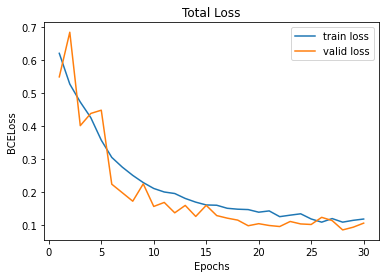

In [ ]:
# visualizing train losses;
ticks = np.arange(1, 31, 1)
plt.plot(ticks, train_loss, label='train loss')
plt.plot(ticks, valid_loss, label='valid loss')
plt.title('Total Loss')
plt.xlabel('Epochs')
plt.ylabel('BCELoss')
plt.legend();

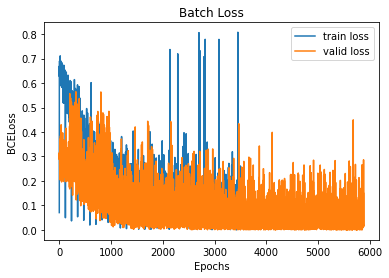

In [ ]:
# visualizing train losses;
ticks = np.arange(1, 31, 1)
plt.plot(batch_t_loss, label='train loss')
plt.plot(batch_v_loss, label='valid loss')
plt.title('Batch Loss')
plt.xlabel('Epochs')
plt.ylabel('BCELoss')
plt.legend();

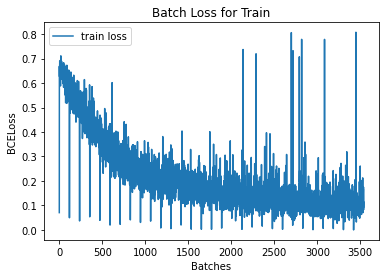

In [ ]:
plt.plot(batch_t_loss, label='train loss')
plt.title('Batch Loss for Train')
plt.xlabel('Batches')
plt.ylabel('BCELoss')
plt.legend();

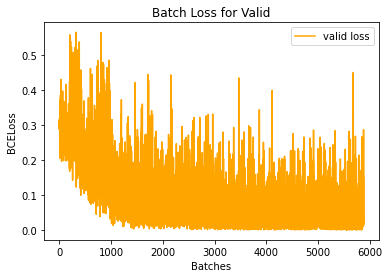

In [ ]:
plt.plot(batch_v_loss, label='valid loss', c='orange')
plt.title('Batch Loss for Valid')
plt.xlabel('Batches')
plt.ylabel('BCELoss')
plt.legend();

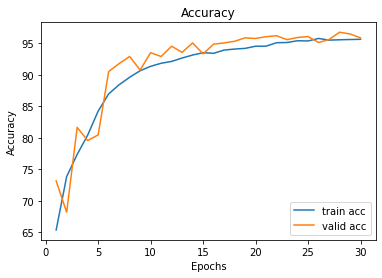

In [ ]:
# visualizing accuracies across training;
ticks = np.arange(1, 31, 1)
plt.plot(ticks, train_acc, label='train acc')
plt.plot(ticks, valid_acc, label='valid acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

## Transfer Learning

In [ ]:
import torchvision.models as models

res_net = models.resnet50( pretrained=True )

# freeze parameters
for param in res_net.parameters():
  param.requires_grad = False 

In [ ]:
res_net.fc

Sequential(
  (0): Linear(in_features=2048, out_features=1, bias=True)
  (1): Sigmoid()
)

In [ ]:
## Update the linear layers
# for the resnet model
res_net.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=1, bias=True),
    nn.Sigmoid()
)

# move model to cuda if available
if use_cuda:
    res_net = res_net.cuda()
    
res_net.fc

Sequential(
  (0): Linear(in_features=2048, out_features=1, bias=True)
  (1): Sigmoid()
)

In [ ]:
# defining num of subprocesses to use for data loading
num_workers = 0
# num of samples per batch
batch_size = 16
# fraction of data to use from the train data as validation
valid_size = 0.25

## Getting a fraction of the dataset to help debug the network
# X_data = train_data[ :4000 ]
# valid_idx =  int( len( X_data ) * 0.25 )
# X_train, X_valid = X_data[ valid_idx: ], X_data[ :valid_idx ]

# Splitting the whole dataset
X_train, X_valid = train_test_split( train_data, test_size=valid_size )


### Get datasets
classes = { 'dog':0, 'cat':1 }
f_train = CatDogData( X_train, classes, 'train', transform['train'] )
f_valid = CatDogData( X_valid, classes, 'valid', transform['test'] )
f_test = CatDogData( test_data, classes, 'test', transform['test'] )

### Prepare dataloaders
data_loaders = { 'train': DataLoader( f_train, batch_size=batch_size, shuffle=True ),
                 'valid': DataLoader( f_valid, batch_size=batch_size ),
                 'test': DataLoader( f_test, batch_size=batch_size ) 
                 }

print( 'Dataloaders preparation complete!')
len(data_loaders['train']), len(data_loaders['valid'])

Dataloaders preparation complete!


(1172, 391)

In [ ]:
# training the resnet model
epochs=15
optimiser = optim.SGD( res_net.parameters(), lr=lr )
res_net, evaluation_res = train( epochs, res_net, data_loaders, optimiser, criterion, 
                          use_cuda, model_path+'res_net.pt' )

Training Started......


==================== Epoch: 1/15 =========================
Train loss: 0.122457 		Valid loss: 0.053493
Train Acc: 95.253840 		Valid Acc: 98.369565
======>ETA: 5180.060769seconds
Validation loss decreased (inf ==> 0.053493) Saving model....
==================== Epoch: 2/15 =========================
Train loss: 0.116444 		Valid loss: 0.049405
Train Acc: 95.451152 		Valid Acc: 98.337596
======>ETA: 233.202379seconds
Validation loss decreased (0.053493 ==> 0.049405) Saving model....
==================== Epoch: 3/15 =========================
Train loss: 0.115522 		Valid loss: 0.043115
Train Acc: 95.312500 		Valid Acc: 98.609335
======>ETA: 233.703620seconds
Validation loss decreased (0.049405 ==> 0.043115) Saving model....
==================== Epoch: 4/15 =========================
Train loss: 0.114533 		Valid loss: 0.045668
Train Acc: 95.477816 		Valid Acc: 98.465473
======>ETA: 232.782373seconds
==================== Epoch: 5/15 =========================
Train loss:

In [ ]:
# Visualizing evaluation metrics
# Getting metrics

batch_t_loss = evaluation_res[0]['batch']
batch_v_loss = evaluation_res[1]['batch']
train_loss = evaluation_res[0]['total']
valid_loss = evaluation_res[1]['total']
train_acc = evaluation_res[2]['train']
valid_acc = evaluation_res[2]['valid']

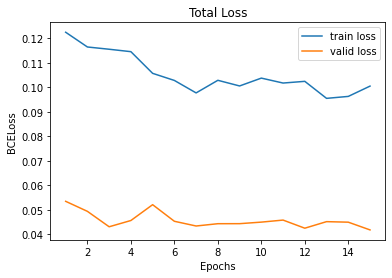

In [ ]:
# visualizing train losses;
ticks = np.arange(1, 16, 1)
plt.plot(ticks, train_loss, label='train loss')
plt.plot(ticks, valid_loss, label='valid loss')
plt.title('Total Loss')
plt.xlabel('Epochs')
plt.ylabel('BCELoss')
plt.legend();

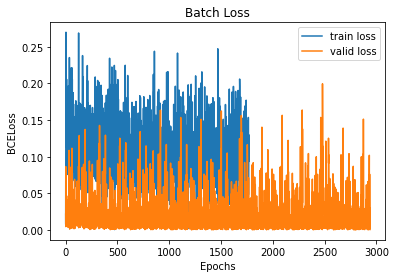

In [ ]:
# visualizing train losses;
ticks = np.arange(1, 16, 1)
plt.plot(batch_t_loss, label='train loss')
plt.plot(batch_v_loss, label='valid loss')
plt.title('Batch Loss')
plt.xlabel('Epochs')
plt.ylabel('BCELoss')
plt.legend();

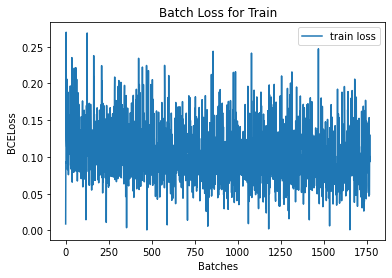

In [ ]:
plt.plot(batch_t_loss, label='train loss')
plt.title('Batch Loss for Train')
plt.xlabel('Batches')
plt.ylabel('BCELoss')
plt.legend();

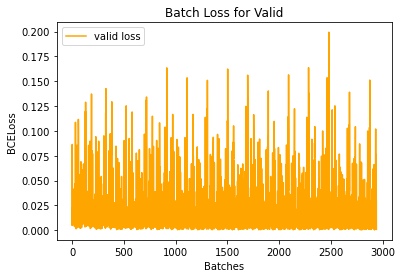

In [ ]:
plt.plot(batch_v_loss, label='valid loss', c='orange')
plt.title('Batch Loss for Valid')
plt.xlabel('Batches')
plt.ylabel('BCELoss')
plt.legend();

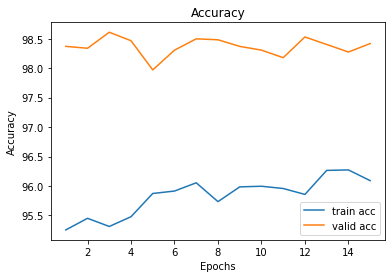

In [ ]:
# visualizing accuracies across training;
ticks = np.arange(1, 16, 1)
plt.plot(ticks, train_acc, label='train acc')
plt.plot(ticks, valid_acc, label='valid acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();